In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 07 - Neural Network with Fibonacci 

### v8 Mean absolute error

by Louis Yang

Use Fibonacci series median instead of median

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

Modified from 'model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool'

Result: 

In [2]:
model_name = 'model_7_CNN_with_Fibonacci_8_mean_absolute_error-prediction'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

In [4]:
def arr_info(arr_list):
    print('shape, min, max, median, stdev')
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

## Input

In [5]:
print('%%% Reading data train_1.csv ... ', end = '', flush = True)
input_df = pd.read_csv("../data/train_1.csv")
print('done!')

%%% Reading data train_1.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

input_data = input_df[input_df_dates].values; input_data

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
test_length = 0  # for predicting
#test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [10]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [11]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2015-11-01', '2016-01-02')

In [12]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [13]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [14]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2016-10-30', '2016-12-31')

In [15]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [16]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Both are Wednesday (2).

#### Y

In [17]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [18]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-01-03', '2016-03-05')

In [19]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [20]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-01-01'
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [21]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-01-01', '2017-03-04')

In [22]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [23]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Both are Sunday (6).

## Fibonacci

In this testing code, we should not include the last y_length days since in the real predicting stage, we don't know their visits.

Here, we don't distinguish between input and output fib_dates.

In [24]:
if test_length:
    fib_dates = input_df_dates[:-test_length]
else:
    fib_dates = input_df_dates
fib_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [25]:
fib_data = input_df[fib_dates].values; fib_data

array([[ 18.,  11.,   5., ...,  19.,  18.,  20.],
       [ 11.,  14.,  15., ...,  45.,  26.,  20.],
       [  1.,   0.,   1., ...,   3.,   4.,  17.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

### Find starting dates

Not using this. Use numpy nan method instead

start_tf = ~np.isnan(fib_data); start_tf

fib_days = len(fib_data[0]); fib_days

index_range = np.arange(fib_days)
def first_true_index(x):
    temp = index_range[x]
    if temp.any():
        return temp[0]
    else:
        return -1
#first_true_index_v = np.vectorize(first_true_index)

start_index = np.array([first_true_index(x) for x in start_tf])

start_index

### Window

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [26]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]

In [27]:
fib_view_list = [fib_data[:, -w:] for w in windows]

In [28]:
fib_median_list = np.array([np.nanmedian(view, axis=-1) 
                            for view in fib_view_list])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [29]:
fib_median_list.T.shape

(145063, 8)

In [30]:
fib_median_na = np.nanmedian(fib_median_list.T, axis=-1)

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [31]:
fib_median_na

array([ 18.25,  21.5 ,   4.  , ...,    nan,    nan,    nan])

In [32]:
fib_median = np.nan_to_num(fib_median_na); fib_median.shape

(145063,)

In [33]:
fib_median

array([ 18.25,  21.5 ,   4.  , ...,   0.  ,   0.  ,   0.  ])

We will use this as the center and part of the result

In [34]:
Y_output_fib = fib_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

In [35]:
X_input_first_day, Y_input_final_day

('2015-11-01', '2016-03-05')

input_data contains X_input and Y_input array

In [36]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates

Index(['2015-11-01', '2015-11-02', '2015-11-03', '2015-11-04', '2015-11-05',
       '2015-11-06', '2015-11-07', '2015-11-08', '2015-11-09', '2015-11-10',
       ...
       '2016-02-25', '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
       '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05'],
      dtype='object', length=126)

In [37]:
input_data = input_df[input_dates].values; input_data

array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
       [ 11.,  14.,  14., ...,  26.,  16.,  16.],
       [  6.,   2.,   5., ...,   1.,   4.,   7.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

##### Convert nan to number 0.

In [38]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
       [ 11.,  14.,  14., ...,  26.,  16.,  16.],
       [  6.,   2.,   5., ...,   1.,   4.,   7.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [39]:
input_data_num.shape

(145063, 126)

### Output Data

In [40]:
X_output_first_day, X_output_final_day, Y_output_final_day

('2016-10-30', '2016-12-31', '2017-03-04')

output_data for this self-testing script contains both X_output and Y_output

In [41]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates

Index(['2016-10-30', '2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03',
       '2016-11-04', '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
       '2016-11-09', '2016-11-10', '2016-11-11', '2016-11-12', '2016-11-13',
       '2016-11-14', '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
       '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
       '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
       '2016-11-29', '2016-11-30', '2016-12-01', '2016-12-02', '2016-12-03',
       '2016-12-04', '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
       '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
       '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-18',
       '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
       '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
       '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object')

In [42]:
output_dates.shape

(63,)

In [43]:
output_data = input_df[output_dates].values; output_data

array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
       [ 15.,  24.,  13., ...,  45.,  26.,  20.],
       [  2.,   6.,   1., ...,   3.,   4.,  17.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

##### Convert nan to number 0.

In [44]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
       [ 15.,  24.,  13., ...,  45.,  26.,  20.],
       [  2.,   6.,   1., ...,   3.,   4.,  17.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [45]:
output_data_num.shape

(145063, 63)

### View

In [46]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [47]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [48]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [49]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [50]:
output_data_log.shape, output_data.shape

((145063, 63), (145063, 63))

input_data_log

output_data_log

In [51]:
# Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

(-1.862645149230957e-08, 1.862645149230957e-08)

In [52]:
# Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

(-2.6077032089233398e-08, 2.6077032089233398e-08)

In [53]:
del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [54]:
gc.collect()

0

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [55]:
input_center = log(fib_median).reshape(-1,1)
output_center = log(fib_median).reshape(-1,1)

In [56]:
input_center

array([[ 1.28443073],
       [ 1.35218252],
       [ 0.69897   ],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

#### Compute Median and Stdev

Here we are not using this median

In [57]:
np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)

array([[ 1.20411998],
       [ 1.14612804],
       [ 0.60205999],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [58]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = 1.0  # Prevent divid by zero
input_scale  # remember sample-wised scale

array([[ 0.28698004],
       [ 0.24215417],
       [ 0.19345186],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [59]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = 1.0  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.25058444],
       [ 0.27659201],
       [ 0.30125919],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [60]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [61]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [62]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

In [63]:
check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

([], [])

In [64]:
# Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

(-8.8817841970012523e-16, 1.1102230246251565e-15)

In [65]:
# Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

In [66]:
del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

236

## Center (Median) and Scale (Stdev) Investigation

#### Input Center

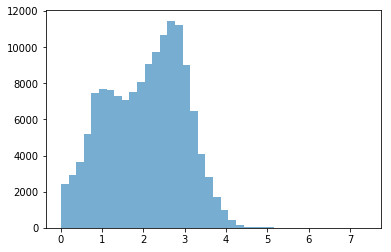

In [67]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.show()

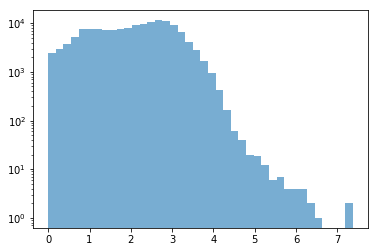

In [68]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Center

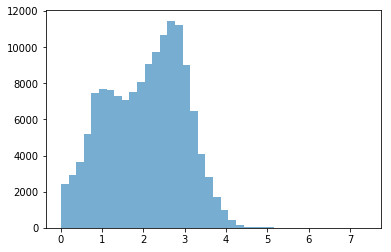

In [69]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.show()

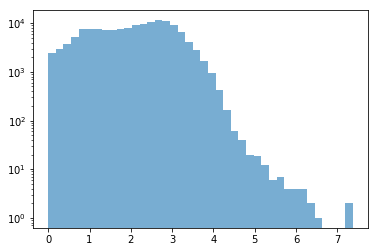

In [70]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Input Scale

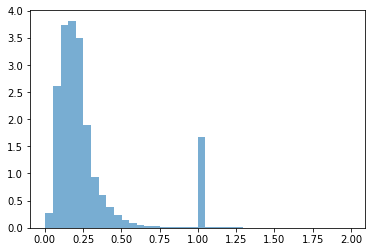

In [71]:
plt.hist(input_scale, bins=40, normed=True, alpha=0.6)
plt.show()

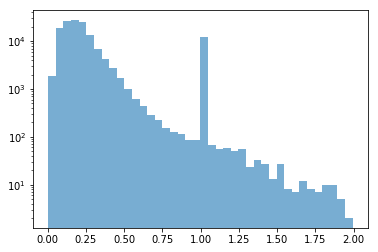

In [72]:
plt.hist(input_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Scale

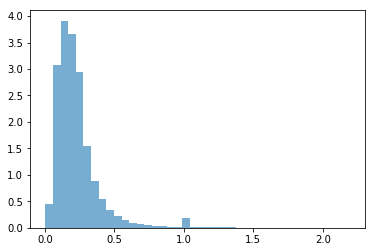

In [73]:
plt.hist(output_scale, bins=40, normed=True, alpha=0.6)
plt.show()

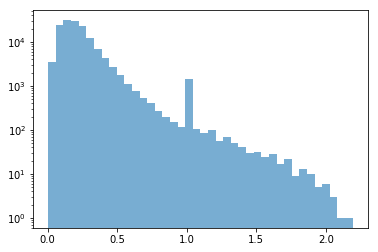

In [74]:
plt.hist(output_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [75]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [76]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
input_gp, output_gp

(array([2, 2, 1, ..., 0, 0, 0]), array([2, 2, 1, ..., 0, 0, 0]))

In [77]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[2291, 22088, 41343, 78354, 927, 60]

In [78]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[2291, 22088, 41343, 78354, 927, 60]

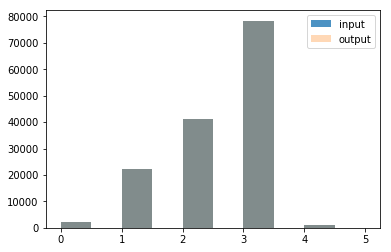

In [79]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

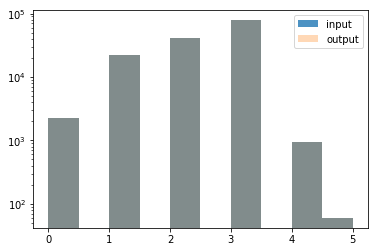

In [80]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

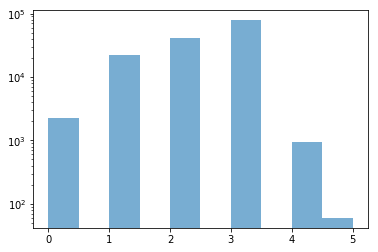

In [81]:
plt.hist(input_gp, alpha=0.6)
plt.yscale('log')
plt.show()

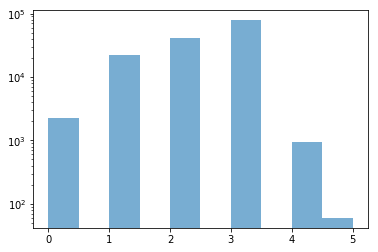

In [82]:
plt.hist(output_gp, alpha=0.6)
plt.yscale('log')
plt.show()

## Make (X,Y) pairs data from data set

day_shift = 0

def make_XY(data, x_length=x_length, y_length=y_length, shift=day_shift):
    if shift == 0:
        return data[:, -x_length-y_length:-y_length], data[:, -y_length:]
    else:
        return data[:, -x_length-y_length-shift:-y_length-shift], data[:, -y_length-shift:-shift]

In [83]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [84]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) No Y_output


#### Original data

In [85]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [86]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

In [87]:
X_train = X_input
Y_train = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

In [88]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

In [89]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

#### Min and max cases examination

np.argmax(Y_input, axis=0)

Y_input[34790]

Y_input_ori[34790]

fib_median[34790]

log(Y_input_ori[34790])

log(fib_median[34790])

np.std(log(Y_input_ori[34790]))

np.std(log(X_input_ori[34790]))

input_scale[34790]

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [90]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [91]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [92]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(),
                                            None))
    return 200. * K.mean(diff, axis=-1)

In [93]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), K.epsilon(),
                          None))
    return 200. * np.nanmean(diff, axis=axis)

def smape_CPMP(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error suggested by CPMP'''
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff, axis=axis)

In [94]:
smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

(200.0, 0.0)

smape_CPMP(np.array([0,1]),np.array([np.nan, 0])), smape_CPMP(np.array([0]),np.array([0]))

In [95]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(109.86142597828301, 146.4244144388739, 0.0)

In [96]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(58.879528613927789, 54.623816383048805)

Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [97]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D

In [98]:
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(120, kernel_size=5, activation='relu')(layer_t)
    layer_t = AveragePooling1D(pool_size=2)(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_absolute_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 63, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 120)           720       
_________________________________________________________________
average_pooling1d_1 (Average (None, 29, 120)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3480)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               417720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_

About 22s for 1 epoch on i5-750 CPU

In [99]:
len(gp_list)

6

In [100]:
epochs_list = [40,40,40,40,60,80]

In [101]:
%%time
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    print('Group:',gp)
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05, verbose=2)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Group: 0
Train on 2176 samples, validate on 115 samples
Epoch 1/40
0s - loss: 0.7360 - k_smape: 190.8949 - val_loss: 0.2181 - val_k_smape: 194.1321
Epoch 2/40
0s - loss: 0.6773 - k_smape: 195.3867 - val_loss: 0.1773 - val_k_smape: 193.4498
Epoch 3/40
0s - loss: 0.6485 - k_smape: 194.4567 - val_loss: 0.1840 - val_k_smape: 193.5119
Epoch 4/40
0s - loss: 0.6355 - k_smape: 192.9020 - val_loss: 0.1928 - val_k_smape: 193.6852
Epoch 5/40
0s - loss: 0.6227 - k_smape: 192.9020 - val_loss: 0.1706 - val_k_smape: 191.1127
Epoch 6/40
0s - loss: 0.6205 - k_smape: 191.5410 - val_loss: 0.1473 - val_k_smape: 192.5629
Epoch 7/40
0s - loss: 0.6069 - k_smape: 191.7518 - val_loss: 0.1405 - val_k_smape: 191.3293
Epoch 8/40
0s - loss: 0.6094 - k_smape: 191.8441 - val_loss: 0.1449 - val_k_smape: 192.2705
Epoch 9/40
0s - loss: 0.6049 - k_smape: 191.3154 - val_loss: 0.1357 - val_k_smape: 192.1780
Epoch 10/40
0s - loss: 0.6002 - k_smape: 191.0113 - val_loss: 0.1413 - val_k_smape: 192.4025
Epoch 11/40
0s - loss: 

6s - loss: 1.0174 - k_smape: 108.9843 - val_loss: 0.9013 - val_k_smape: 130.5317
Epoch 9/40
6s - loss: 1.0173 - k_smape: 108.7108 - val_loss: 0.8984 - val_k_smape: 130.9635
Epoch 10/40
6s - loss: 1.0154 - k_smape: 108.4044 - val_loss: 0.9039 - val_k_smape: 132.2964
Epoch 11/40
6s - loss: 1.0145 - k_smape: 108.4258 - val_loss: 0.9052 - val_k_smape: 130.7588
Epoch 12/40
6s - loss: 1.0118 - k_smape: 107.9691 - val_loss: 0.9106 - val_k_smape: 131.8054
Epoch 13/40
6s - loss: 1.0073 - k_smape: 107.7921 - val_loss: 0.9087 - val_k_smape: 131.7520
Epoch 14/40
6s - loss: 1.0075 - k_smape: 107.7181 - val_loss: 0.9065 - val_k_smape: 132.3688
Epoch 15/40
6s - loss: 1.0040 - k_smape: 107.3811 - val_loss: 0.9088 - val_k_smape: 132.6804
Epoch 16/40
6s - loss: 1.0069 - k_smape: 107.4454 - val_loss: 0.9069 - val_k_smape: 133.2005
Epoch 17/40
6s - loss: 1.0062 - k_smape: 107.4236 - val_loss: 0.9051 - val_k_smape: 130.8076
Epoch 18/40
6s - loss: 1.0036 - k_smape: 107.1416 - val_loss: 0.9062 - val_k_smape:

0s - loss: 1.3491 - k_smape: 87.9703 - val_loss: 1.0631 - val_k_smape: 91.9697
Epoch 18/60
0s - loss: 1.3638 - k_smape: 87.8713 - val_loss: 0.9742 - val_k_smape: 85.3210
Epoch 19/60
0s - loss: 1.3250 - k_smape: 86.1980 - val_loss: 1.0883 - val_k_smape: 92.4974
Epoch 20/60
0s - loss: 1.3350 - k_smape: 85.2974 - val_loss: 0.9758 - val_k_smape: 84.9530
Epoch 21/60
0s - loss: 1.3311 - k_smape: 85.4413 - val_loss: 1.0266 - val_k_smape: 90.7549
Epoch 22/60
0s - loss: 1.3244 - k_smape: 84.4337 - val_loss: 0.9807 - val_k_smape: 86.6685
Epoch 23/60
0s - loss: 1.2659 - k_smape: 84.3433 - val_loss: 0.8686 - val_k_smape: 82.5392
Epoch 24/60
0s - loss: 1.2577 - k_smape: 82.2537 - val_loss: 0.9231 - val_k_smape: 85.5331
Epoch 25/60
0s - loss: 1.2303 - k_smape: 81.6023 - val_loss: 0.8946 - val_k_smape: 83.8923
Epoch 26/60
0s - loss: 1.2296 - k_smape: 81.1234 - val_loss: 0.9088 - val_k_smape: 85.6979
Epoch 27/60
0s - loss: 1.2161 - k_smape: 80.7805 - val_loss: 0.8586 - val_k_smape: 82.7950
Epoch 28/60

0s - loss: 2.8227 - k_smape: 74.0854 - val_loss: 0.6503 - val_k_smape: 86.0700
Epoch 58/80
0s - loss: 2.8811 - k_smape: 74.2947 - val_loss: 0.6229 - val_k_smape: 83.4351
Epoch 59/80
0s - loss: 3.0827 - k_smape: 78.5194 - val_loss: 0.5906 - val_k_smape: 80.5961
Epoch 60/80
0s - loss: 2.9739 - k_smape: 77.2728 - val_loss: 0.5579 - val_k_smape: 77.9656
Epoch 61/80
0s - loss: 2.8442 - k_smape: 76.0832 - val_loss: 0.5440 - val_k_smape: 76.0868
Epoch 62/80
0s - loss: 3.2440 - k_smape: 73.9362 - val_loss: 0.5318 - val_k_smape: 76.0693
Epoch 63/80
0s - loss: 2.8363 - k_smape: 71.0954 - val_loss: 0.5366 - val_k_smape: 76.7598
Epoch 64/80
0s - loss: 2.9982 - k_smape: 71.7417 - val_loss: 0.5608 - val_k_smape: 78.4704
Epoch 65/80
0s - loss: 3.0186 - k_smape: 72.3264 - val_loss: 0.5816 - val_k_smape: 80.5409
Epoch 66/80
0s - loss: 2.9738 - k_smape: 70.7023 - val_loss: 0.6001 - val_k_smape: 82.5703
Epoch 67/80
0s - loss: 3.0004 - k_smape: 75.6477 - val_loss: 0.6199 - val_k_smape: 83.9072
Epoch 68/80

### Training History

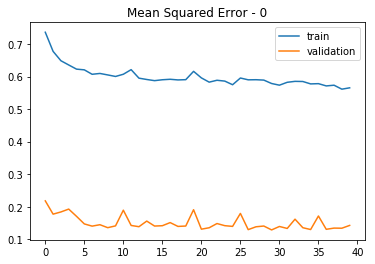

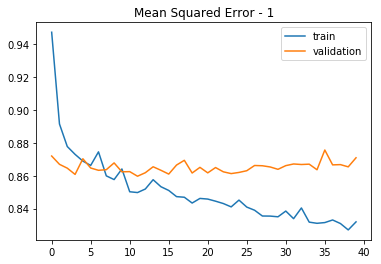

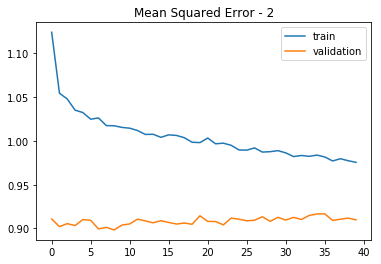

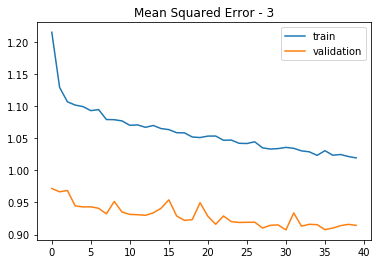

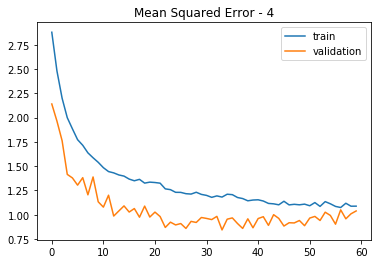

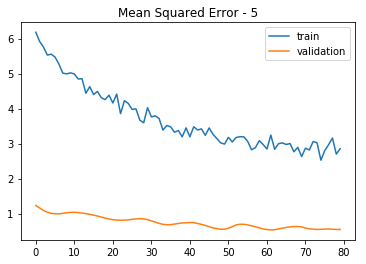

In [102]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

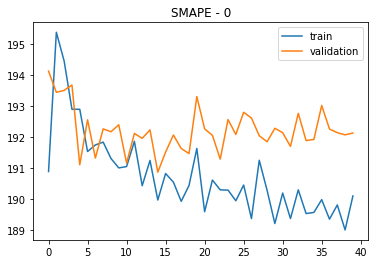

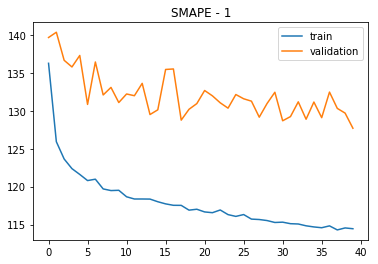

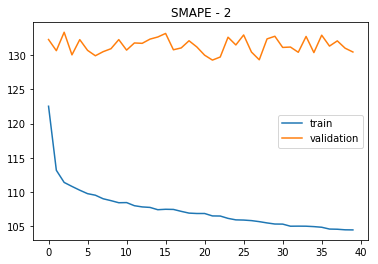

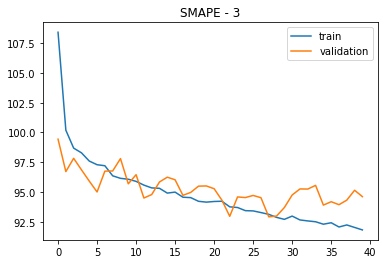

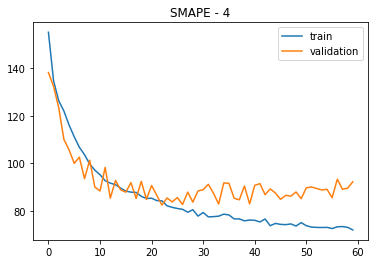

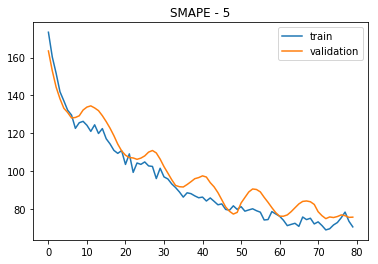

In [103]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

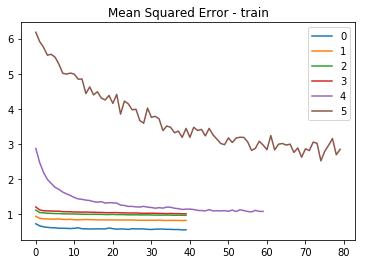

In [104]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

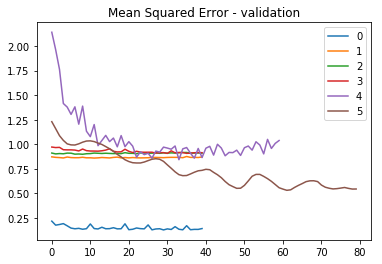

In [105]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

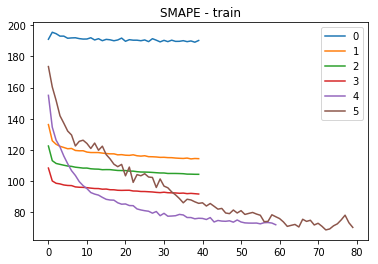

In [106]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

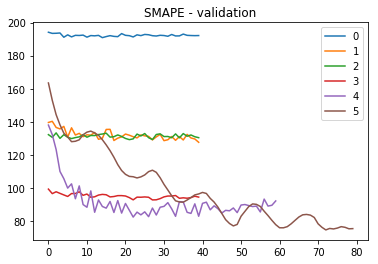

In [107]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using for Output Set

In [108]:
if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))

### Predict for Output Set

In [109]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4
5


Find the original index

In [110]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [111]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [112]:
for o in output_index_list:
    print(o.shape)

(2291,)
(22088,)
(41343,)
(78354,)
(927,)
(60,)


In [113]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([    54,    117,    148, ..., 123025, 139119, 140151])

In [114]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [115]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)

In [116]:
# Inverse transform Y of output
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

#### Check predict output

In [117]:
Y_output_pred

array([[  3.36488038e-01,   4.56610680e-01,   4.97319609e-01, ...,
          3.41851115e-01,   3.22394013e-01,   2.92190790e-01],
       [ -2.69416869e-01,  -2.53960013e-01,  -2.31095046e-01, ...,
         -2.09944576e-01,  -2.05525577e-01,  -1.54156774e-01],
       [ -2.17279613e-01,  -1.50021568e-01,  -1.24853253e-02, ...,
          2.46957541e-02,   1.13132596e-03,  -1.39285371e-01],
       ..., 
       [ -3.94611416e-05,  -1.15771887e-04,   2.99551593e-05, ...,
          3.70842899e-04,   4.40085627e-04,   5.68713222e-05],
       [ -3.94611416e-05,  -1.15771887e-04,   2.99551593e-05, ...,
          3.70842899e-04,   4.40085627e-04,   5.68713222e-05],
       [ -3.94611416e-05,  -1.15771887e-04,   2.99551593e-05, ...,
          3.70842899e-04,   4.40085627e-04,   5.68713222e-05]], dtype=float32)

In [118]:
Y_output_pred_ori

array([[  2.23748805e+01,   2.40524535e+01,   2.46478691e+01, ...,
          2.24473250e+01,   2.21855635e+01,   2.17850087e+01],
       [  1.79523891e+01,   1.81398799e+01,   1.84206372e+01, ...,
          1.86840077e+01,   1.87394835e+01,   1.93959522e+01],
       [  3.30043636e+00,   3.50582820e+00,   3.95688320e+00, ...,
          4.08639200e+00,   4.00392540e+00,   3.53951031e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   6.89766821e-05, ...,
          8.54262006e-04,   1.01384820e-03,   1.30959633e-04],
       [  0.00000000e+00,   0.00000000e+00,   6.89766821e-05, ...,
          8.54262006e-04,   1.01384820e-03,   1.30959633e-04],
       [  0.00000000e+00,   0.00000000e+00,   6.89766821e-05, ...,
          8.54262006e-04,   1.01384820e-03,   1.30959633e-04]])

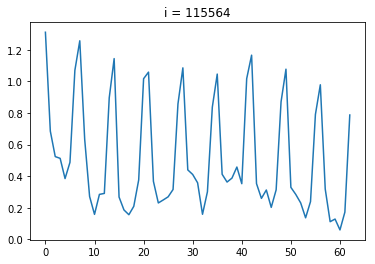

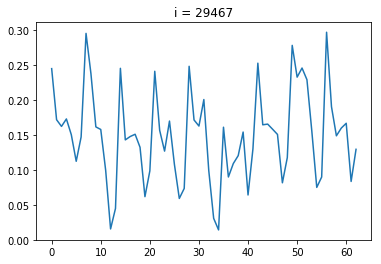

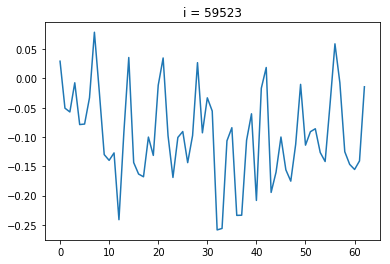

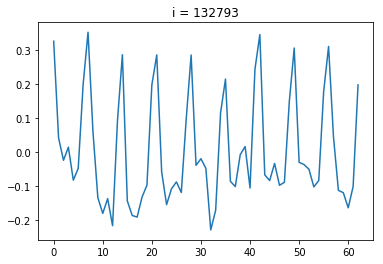

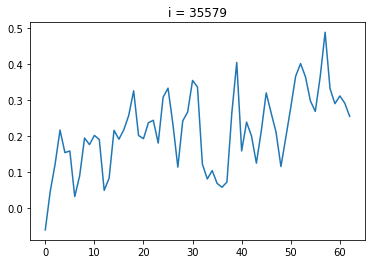

array([115564,  29467,  59523, 132793,  35579])

In [119]:
examine(Y_output_pred)

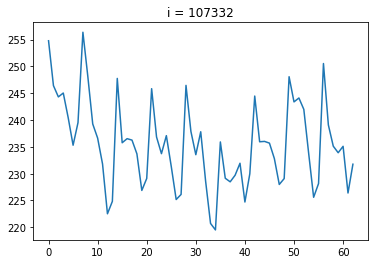

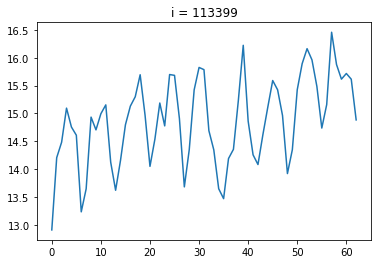

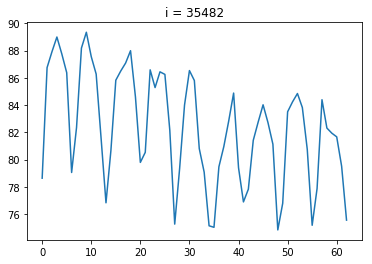

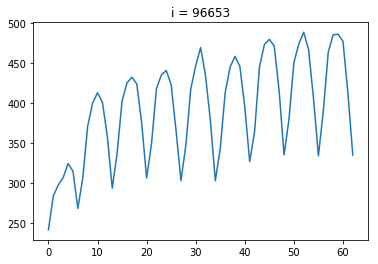

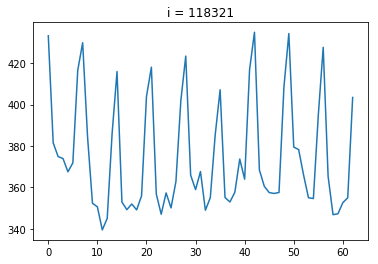

array([107332, 113399,  35482,  96653, 118321])

In [120]:
examine(Y_output_pred_ori)

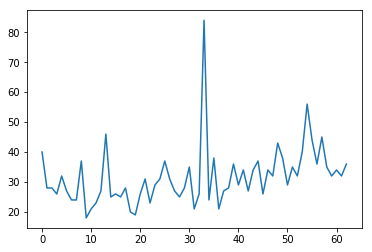

In [121]:
view(X_output_ori[126420])

## Self-Testing

In [122]:
# SMAPE assuming nan == 0
if test_length: 
    model_smape_score_0 = smape(Y_output_ori, Y_output_pred_ori)
    print(model_smape_score_0)

In [123]:
# SMAPE score excluding nan (Correct one)
if test_length: 
    model_smape_score = smape(Y_output_raw, Y_output_pred_ori)
    print(model_smape_score)

In [124]:
model_name

'model_7_CNN_with_Fibonacci_8_mean_absolute_error-prediction'

In [125]:
epochs_list#, epochs_list2

[40, 40, 40, 40, 60, 80]

Self-testing SMAPE scores:

50.523 - Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.516 - Model 6.0.1 CNN - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.686 - Model 6.3.0 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.265 - Model 6.3.1 - (40,40,40,60,60) epoches

50.289 - Model 6.3.1 - (40,40,40,60,60) epoches, run 2

51.017 - Model 6.3.2 - (20,40,20,80,80) epoches

50.773 - Model 6.3.3 group by scale (= 0.,< 1.4,< 2.5,< 3.8,) - (20,30,20,20,30) epoches

50.434 - Model 6.3.4 group by scale (= 0.,< 2,< 4,< 5,) - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,60,60) epoches

50.283 - Model 6.3.5 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

50.923 - Model 6.3.6 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

50.895 - Model 6.3.7 more group (= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 5)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

48.371 - Model 7.0.0 Fibonacci - group(= 0.,< 1,< 2,< 4,< 5,) - Conv(60, 5)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, (40,40,40,40,60,80) epoches

49.392 - Model 7.1.0 Fibonacci - range corrected :-y_length

47.657 - Model 7.00 Original Fibonacci median without neural network

48.159 - Model 49 days median

Correct SMAPE:

45.879 - Model 7.00 Original Fibonacci median without neural network

46.461 - Model 7.00.1 Original Fibonacci median without neural network with nan replaced by 0

46.998 - Model 49 days median

47.701 - Model 49 days median with nan replaced by 0

45.248 - Model 7.1.1 CNN Fibonacci - range corrected :-y_length - score corrected

46.103

44.892 - Model 7.2.0 CNN and original Fibonacci Combined

44.797 - Model 7.4.0 SMAPE by CPMP (same as mine)

## Group Scores
For self-testing stage only

In [126]:
# Prediction Y_output in group
Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]    

In [127]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [128]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [129]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

In [130]:
if test_length: print(count_not_nan(Y_output_raw))

In [131]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
                  in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape = [smape(Y, Y_p) for Y, Y_p 
                in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [132]:
if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape_score, '%6.2f' % model_smape_score_0)

In [135]:
if test_length:
    print(n_not_nan_gp)

if test_length:
    x_tmp = 0.
    for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
        s_tmp = smape(Y, Y_p) * len(Y)
        print(s_tmp / tot_n)
        x_tmp += s_tmp
    print('SMAPE(0):', '%6.2f' % (x_tmp / tot_n))

#the correct one (excluding nan)
n_not_nan = count_not_nan(Y_output_raw)
x_tmp = 0.
for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list):
    s_tmp = smape(Y, Y_p) * count_not_nan(Y)
    print(s_tmp / n_not_nan)
    x_tmp += s_tmp
x_tmp / n_not_nan

## Compare

Y_input_ori = input_data[:,-y_length:]
X_input_ori = input_data[:,:x_length]
X_output_ori = output_data[:,:x_length]

In [136]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

In [137]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True, xlim=None, ylim=None, yscale='linear'):
    plt.yscale(yscale)
    for x in x_list:
        plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None, xlim=None, ylim=None, yscale='linear'):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i), xlim=xlim, ylim=ylim, yscale=yscale)
    return list(view_list)

view_list = None

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [138]:
view_list

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

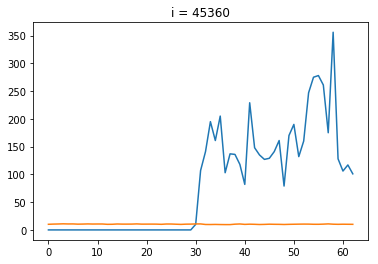

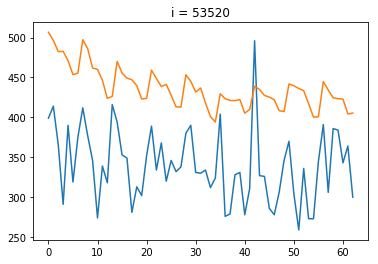

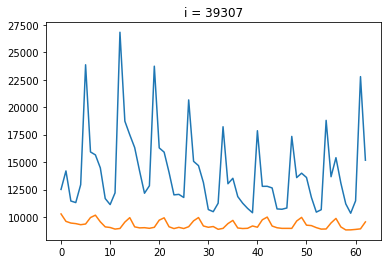

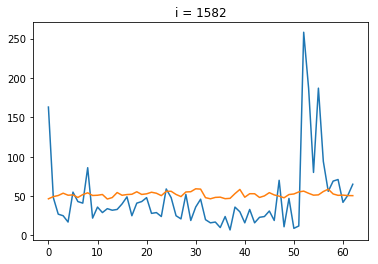

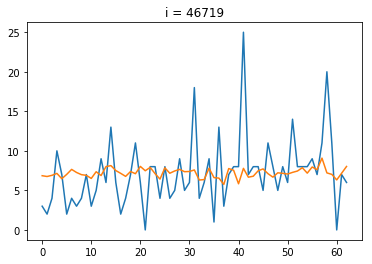

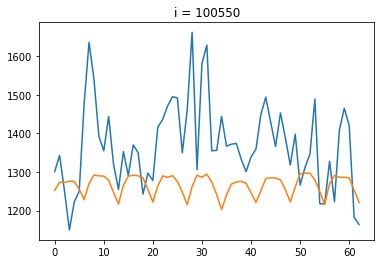

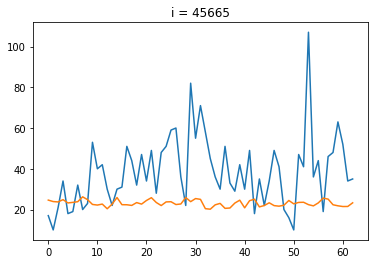

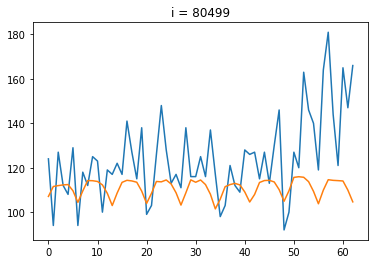

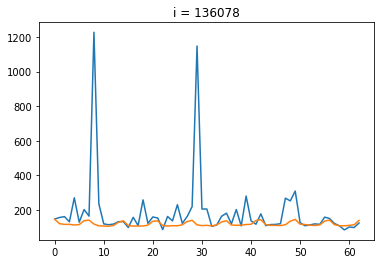

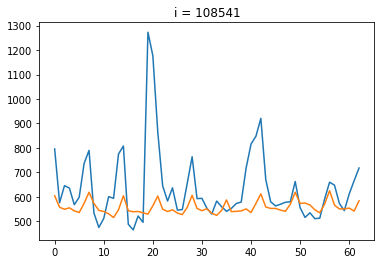

In [139]:
view_list = comp_examine(Y_input_ori, Y_output_pred_ori, view_list=view_list)

In [140]:
if test_length:
    view_list = comp_examine(Y_output_ori, Y_output_pred_ori, view_list=view_list)

In [141]:
if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output),
                             view_list=view_list)

In [142]:
if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
                             view_list=view_list)

comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

In [143]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

view_list_review = [score < model_smape_score for score in view_list_smape]; view_list_review

view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

#### Good cases

examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
             view_list=view_list_good)

#### Bad cases

examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
             view_list=view_list_bad)

print(input_center[view_list_good].reshape(-1))
print(input_center[view_list_bad].reshape(-1))

output_gp[view_list_good]

output_gp[view_list_bad]

gp_smape

gp_n

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

input_center[i], output_center[i], input_scale[i], output_scale[i]

### SMAPE Distribution Investigation

#### SMAPE of the model for each data

In [145]:
if test_length:
    smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
                                in zip(Y_output_pred_ori, Y_output_raw)])
    smape_Y_pred = np.nan_to_num(smape_Y_pred_na)

In [146]:
if test_length:
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

In [147]:
if test_length:
    smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]

In [148]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

In [149]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [150]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [151]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [152]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

#### SMAPE for Fibonacci median

What if we replace the group 1 prediction by fib median

In [153]:
Y_output_fib_list = [fib_median[output_gp == gp].reshape(-1,1) 
                     for gp in gp_list]

In [154]:
Y_output_fib_list[1]

array([[ 4. ],
       [ 8.5],
       [ 4. ],
       ..., 
       [ 2. ],
       [ 5.5],
       [ 2. ]])

In [155]:
# The actual score with nan
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]
    print('Model|', 'Fib|', 'number in the group')
    print('-|-|-')
    for score1, score2, n in zip(gp_smape, gp_smape_fib, gp_n):
        print('%3.3f |'%score1, '%3.3f|'%score2, n)

In [156]:
model_name

'model_7_CNN_with_Fibonacci_8_mean_absolute_error-prediction'

#### model_7_CNN_with_Fibonacci_8_mean_absolute_error 3
Model| Fib| number in the group
-|-|-
162.983 | 115.887| 3422
64.946 | 61.823| 23105
44.284 | 45.496| 40264
36.073 | 40.368| 77416
38.975 | 40.033| 790
31.033 | 33.144| 66

#### model_7_CNN_with_Fibonacci_8_mean_absolute_error 2
Model| Fib| number in the group
-|-|-
159.379 | 115.887| 3422
66.444 | 61.823| 23105
44.428 | 45.496| 40264
35.696 | 40.368| 77416
39.093 | 40.033| 790
31.868 | 33.144| 66

#### model_7_CNN_with_Fibonacci_8_mean_absolute_error 1
Model| Fib| number in the group
-|-|-
162.663 | 115.887| 3422
64.746 | 61.823| 23105
44.411 | 45.496| 40264
35.756 | 40.368| 77416
39.302 | 40.033| 790
31.761 | 33.144| 66

#### model_7_CNN_with_Fibonacci_6_Wider_2_conv_120_Averagepool 2
Model| Fib| number in the group
-|-|-
189.454 | 115.887| 3422
64.650 | 61.823| 23105
44.517 | 45.496| 40264
37.069 | 40.368| 77416
42.249 | 40.033| 790
32.558 | 33.144| 66

#### model_7_CNN_with_Fibonacci_6_Wider_2_conv_120_Averagepool 1
Model| Fib| number in the group
-|-|-
188.694 | 115.887| 3422
64.942 | 61.823| 23105
44.529 | 45.496| 40264
37.544 | 40.368| 77416
42.682 | 40.033| 790
33.041 | 33.144| 66

#### model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 4
Model| Fib| number in the group
-|-|-
188.001 | 115.887| 3422
64.177 | 61.823| 23105
44.471 | 45.496| 40264
39.183 | 40.368| 77416
41.828 | 40.033| 790
32.492 | 33.144| 66

#### model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 3
Model| Fib| number in the group
-|-|-
187.650 | 115.887| 3422
64.070 | 61.823| 23105
44.297 | 45.496| 40264
37.121 | 40.368| 77416
40.865 | 40.033| 790
32.989 | 33.144| 66

#### model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 2
Model| Fib| number in the group
-|-|-
189.535 | 115.887| 3422
64.387 | 61.823| 23105
44.714 | 45.496| 40264
36.983 | 40.368| 77416
40.710 | 40.033| 790
33.270 | 33.144| 66

#### model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1
Model| Fib| number in the group
-|-|-
187.501 | 115.887| 3422
64.454 | 61.823| 23105
44.521 | 45.496| 40264
38.306 | 40.368| 77416
40.331 | 40.033| 790
33.218 | 33.144| 66

#### model_7_CNN_with_Fibonacci_5_Deeper_0_Initial 1
Model| Fib| number in the group
-|-|-
187.696 | 115.887| 3422
65.540 | 61.823| 23105
45.246 | 45.496| 40264
37.847 | 40.368| 77416
41.319 | 40.033| 790
32.575 | 33.144| 66

#### model_7_CNN_with_Fibonacci_4
Model| Fib| number in the group
-|-|-
152.096 | 115.887| 3422
63.372 | 61.823| 23105
44.779 | 45.496| 40264
37.594 | 40.368| 77416
42.546 | 40.033| 790
33.056 | 33.144| 66

# **Fib do better in group 0 and 1!!!**

#### SMAPE distribution for Fib

In [157]:
if test_length:
    smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
                               in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(smape_Y_fib_na)

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

In [158]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

In [159]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [160]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [161]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [162]:
Y_output_fib.shape

(145063, 1)

In [163]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [164]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [165]:
# The combined result
Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori

In [166]:
Y_output_fmc_ori

array([[ 22.37488051,  24.05245345,  24.64786907, ...,  22.447325  ,
         22.18556354,  21.78500869],
       [ 17.95238913,  18.13987986,  18.42063718, ...,  18.68400768,
         18.73948353,  19.39595222],
       [  4.        ,   4.        ,   4.        , ...,   4.        ,
          4.        ,   4.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [167]:
if test_length: 
    model_combined_smape_score = smape(Y_output_fmc_ori, Y_output_raw)
    print('%6.3f' % model_combined_smape_score, '(%6.3f)' % model_smape_score)

In [168]:
model_name

'model_7_CNN_with_Fibonacci_8_mean_absolute_error-prediction'

#### Combined Scores:
43.174 (44.159) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 3

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

43.038 (43.990) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 1

43.479 (44.659) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 3

43.804 (45.033) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.948 (46.090) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 4

43.762 (44.885) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 3

43.805 (44.996) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 2

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [169]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [170]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_fmc_ori, columns = Y_output_dates)
result_df

2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
0        22.374881   24.052453   24.647869   25.828824   24.768393   
1        17.952389   18.139880   18.420637   19.388900   18.505548   
2         4.000000    4.000000    4.000000    4.000000    4.000000   
3        17.526205   16.530973   16.368863   16.793149   16.118281   
4        11.322075   12.267276   12.595709   13.262567   12.813727   
5        20.261635   19.315359   19.048160   19.689002   18.883179   
6         8.500000    8.500000    8.500000    8.500000    8.500000   
7        47.935333   44.158730   43.339328   44.560813   42.405537   
8        36.265032   34.120889   34.528033   36.062908   34.606758   
9        26.772032   30.506352   31.301242   32.194463   31.711622   
10       31.865783   30.056673   30.004340   31.662065   29.736961   
11       21.938314   21.555415   21.206099   21.429187   20.582736   
12        4.000000    4.000000    4.000000    4.000000    4.000000   
13       15.737208   16.428607   16.466478   17.048160   16.521607   
14       44.713782   47.316207   47.763897   49.167746   48.155825   
15       37.454469   38.452448   38.082151   39.126793   37.272892   
16       25.126698   27.668632   29.379549   32.168088   30.440055   
17        8.750000    8.750000    8.750000    8.750000    8.750000   
18       15.193642   15.693021   15.858639   16.469309   15.948037   
19        8.500000    8.500000    8.500000    8.500000    8.500000   
20       39.262772   48.934326   51.236548   54.310305   53.241376   
21       21.036560   20.477675   20.345685   20.670305   20.019692   
22       29.844769   32.059522   32.333154   32.822588   31.462290   
23       42.838263   42.712369   41.671231   42.942484   40.823085   
24       73.635405   70.862863   70.366923   72.492486   68.904604   
25       16.778067   16.258568   16.464468   16.938495   16.410324   
26       33.988702   46.017329   48.627766   51.134782   51.050356   
27       10.158532   10.813826   10.933910   11.430662   11.053292   
28       29.951795   30.508803   30.829669   31.348283   30.775717   
29       10.874038   10.861784   10.731411   10.974021   10.465397   
...            ...         ...         ...         ...         ...   
145033   29.386381   32.875699   33.587024   36.096361   34.408082   
145034    6.278550    5.975141    6.106543    6.725779    6.083281   
145035    6.250000    6.250000    6.250000    6.250000    6.250000   
145036    2.000000    2.000000    2.000000    2.000000    2.000000   
145037    5.250000    5.250000    5.250000    5.250000    5.250000   
145038   18.220445   18.536962   18.628199   19.371468   18.723141   
145039   18.387094   20.598063   21.072367   21.884601   21.135808   
145040    2.000000    2.000000    2.000000    2.000000    2.000000   
145041    7.000000    7.000000    7.000000    7.000000    7.000000   
145042    1.000000    1.000000    1.000000    1.000000    1.000000   
145043    7.250000    7.250000    7.250000    7.250000    7.250000   
145044    9.837533   11.023938   11.402406   13.256650   12.107034   
145045    1.000000    1.000000    1.000000    1.000000    1.000000   
145046    8.250000    8.250000    8.250000    8.250000    8.250000   
145047    1.000000    1.000000    1.000000    1.000000    1.000000   
145048    4.500000    4.500000    4.500000    4.500000    4.500000   
145049    7.500000    7.500000    7.500000    7.500000    7.500000   
145050    2.000000    2.000000    2.000000    2.000000    2.000000   
145051    8.031880    9.510974    9.913779   12.245718   11.114755   
145052   15.441472   13.880847   13.158627   13.576261   12.371911   
145053    5.500000    5.500000    5.500000    5.500000    5.500000   
145054   25.555983   29.620588   30.469274   33.508193   31.364768   
145055    2.000000    2.000000    2.000000    2.000000    2.000000   
145056    1.169190    1.541481    1.625926    2.000744    1.852392   
145057    0.000000    0.000000    0.000000    0.000000    0.000000   
145058    8.220619

In [171]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
0        22.374881   24.052453   24.647869   25.828824   24.768393   
1        17.952389   18.139880   18.420637   19.388900   18.505548   
2         4.000000    4.000000    4.000000    4.000000    4.000000   
3        17.526205   16.530973   16.368863   16.793149   16.118281   
4        11.322075   12.267276   12.595709   13.262567   12.813727   
5        20.261635   19.315359   19.048160   19.689002   18.883179   
6         8.500000    8.500000    8.500000    8.500000    8.500000   
7        47.935333   44.158730   43.339328   44.560813   42.405537   
8        36.265032   34.120889   34.528033   36.062908   34.606758   
9        26.772032   30.506352   31.301242   32.194463   31.711622   
10       31.865783   30.056673   30.004340   31.662065   29.736961   
11       21.938314   21.555415   21.206099   21.429187   20.582736   
12        4.000000    4.000000    4.000000    4.000000    4.000000   
13       15.737208   16.428607   16.466478   17.048160   16.521607   
14       44.713782   47.316207   47.763897   49.167746   48.155825   
15       37.454469   38.452448   38.082151   39.126793   37.272892   
16       25.126698   27.668632   29.379549   32.168088   30.440055   
17        8.750000    8.750000    8.750000    8.750000    8.750000   
18       15.193642   15.693021   15.858639   16.469309   15.948037   
19        8.500000    8.500000    8.500000    8.500000    8.500000   
20       39.262772   48.934326   51.236548   54.310305   53.241376   
21       21.036560   20.477675   20.345685   20.670305   20.019692   
22       29.844769   32.059522   32.333154   32.822588   31.462290   
23       42.838263   42.712369   41.671231   42.942484   40.823085   
24       73.635405   70.862863   70.366923   72.492486   68.904604   
25       16.778067   16.258568   16.464468   16.938495   16.410324   
26       33.988702   46.017329   48.627766   51.134782   51.050356   
27       10.158532   10.813826   10.933910   11.430662   11.053292   
28       29.951795   30.508803   30.829669   31.348283   30.775717   
29       10.874038   10.861784   10.731411   10.974021   10.465397   
...            ...         ...         ...         ...         ...   
145033   29.386381   32.875699   33.587024   36.096361   34.408082   
145034    6.278550    5.975141    6.106543    6.725779    6.083281   
145035    6.250000    6.250000    6.250000    6.250000    6.250000   
145036    2.000000    2.000000    2.000000    2.000000    2.000000   
145037    5.250000    5.250000    5.250000    5.250000    5.250000   
145038   18.220445   18.536962   18.628199   19.371468   18.723141   
145039   18.387094   20.598063   21.072367   21.884601   21.135808   
145040    2.000000    2.000000    2.000000    2.000000    2.000000   
145041    7.000000    7.000000    7.000000    7.000000    7.000000   
145042    1.000000    1.000000    1.000000    1.000000    1.000000   
145043    7.250000    7.250000    7.250000    7.250000    7.250000   
145044    9.837533   11.023938   11.402406   13.256650   12.107034   
145045    1.000000    1.000000    1.000000    1.000000    1.000000   
145046    8.250000    8.250000    8.250000    8.250000    8.250000   
145047    1.000000    1.000000    1.000000    1.000000    1.000000   
145048    4.500000    4.500000    4.500000    4.500000    4.500000   
145049    7.500000    7.500000    7.500000    7.500000    7.500000   
145050    2.000000    2.000000    2.000000    2.000000    2.000000   
145051    8.031880    9.510974    9.913779   12.245718   11.114755   
145052   15.441472   13.880847   13.158627   13.576261   12.371911   
145053    5.500000    5.500000    5.500000    5.500000    5.500000   
145054   25.555983   29.620588   30.469274   33.508193   31.364768   
145055    2.000000    2.000000    2.000000    2.000000    2.000000   
145056    1.169190    1.541481    1.625926    2.000744    1.852392   
145057    0.000000    0.000000    0.000000    0.000000    0.000000   
145058    8.220619

In [172]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

Page        date  \
0                  2NE1_zh.wikipedia.org_all-access_spider  2017-01-01   
1                   2PM_zh.wikipedia.org_all-access_spider  2017-01-01   
2                    3C_zh.wikipedia.org_all-access_spider  2017-01-01   
3               4minute_zh.wikipedia.org_all-access_spider  2017-01-01   
4        52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  2017-01-01   
5                  5566_zh.wikipedia.org_all-access_spider  2017-01-01   
6                91Days_zh.wikipedia.org_all-access_spider  2017-01-01   
7                 A'N'D_zh.wikipedia.org_all-access_spider  2017-01-01   
8                 AKB48_zh.wikipedia.org_all-access_spider  2017-01-01   
9                 ASCII_zh.wikipedia.org_all-access_spider  2017-01-01   
10                ASTRO_zh.wikipedia.org_all-access_spider  2017-01-01   
11       Ahq_e-Sports_Club_zh.wikipedia.org_all-access_...  2017-01-01   
12       All_your_base_are_belong_to_us_zh.wikipedia.or...  2017-01-01   
13              AlphaGo_zh.wikipedia.org_all-access_spider  2017-01-01   
14              Android_zh.wikipedia.org_all-access_spider  2017-01-01   
15           Angelababy_zh.wikipedia.org_all-access_spider  2017-01-01   
16                Apink_zh.wikipedia.org_all-access_spider  2017-01-01   
17             Apple_II_zh.wikipedia.org_all-access_spider  2017-01-01   
18               As_One_zh.wikipedia.org_all-access_spider  2017-01-01   
19            B-PROJECT_zh.wikipedia.org_all-access_spider  2017-01-01   
20                 B1A4_zh.wikipedia.org_all-access_spider  2017-01-01   
21                 BDSM_zh.wikipedia.org_all-access_spider  2017-01-01   
22                BEAST_zh.wikipedia.org_all-access_spider  2017-01-01   
23              BIGBANG_zh.wikipedia.org_all-access_spider  2017-01-01   
24           BLACK_PINK_zh.wikipedia.org_all-access_spider  2017-01-01   
25               BLEACH_zh.wikipedia.org_all-access_spider  2017-01-01   
26                 BTOB_zh.wikipedia.org_all-access_spider  2017-01-01   
27       Beautiful_Mind_zh.wikipedia.org_all-access_spider  2017-01-01   
28               Beyond_zh.wikipedia.org_all-access_spider  2017-01-01   
29                  Big_zh.wikipedia.org_all-access_spider  2017-01-01   
...                                                    ...         ...   
9138939  Sin_senos_sí_hay_paraíso_es.wikipedia.org_all-...  2017-03-04   
9138940  Anexo:Medallero_de_los_Juegos_Olímpicos_de_Río...  2017-03-04   
9138941  Arrival_(película)_es.wikipedia.org_all-access...  2017-03-04   
9138942  Anexo:Baloncesto_en_los_Juegos_Olímpicos_de_Rí...  2017-03-04   
9138943  Hasta_que_te_conocí_(serie_de_televisión)_es.w...  2017-03-04   
9138944  Westworld_(serie_de_televisión)_es.wikipedia.o...  2017-03-04   
9138945        Milénico_es.wikipedia.org_all-access_spider  2017-03-04   
9138946  Moonlight_(película)_es.wikipedia.org_all-acce...  2017-03-04   
9138947  Sully_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138948  Pulsaciones_(serie_de_televisión)_es.wikipedia...  2017-03-04   
9138949  2091_(serie_de_televisión)_es.wikipedia.org_al...  2017-03-04   
9138950  Campeonato_Sudamericano_de_Fútbol_Sub-20_de_20...  2017-03-04   
9138951  Split_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138952  Huracán_Matthew_es.wikipedia.org_all-access_sp...  2017-03-04   
9138953  Fences_(película)_es.wikipedia.org_all-access_...  2017-03-04   
9138954  Logan_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138955  La_doña_(telenovela_de_2016)_es.wikipedia.org_...  2017-03-04   
9138956  RTS_(canal_de_televisión)_es.wikipedia.org_all...  2017-03-04   
9138957  La_ley_del_corazón_es.wikipedia.org_all-access...  2017-03-04   
9138958  The_Crown_(serie_de_televisión)_es.wikipedia.o...  2017-03-04   
9138959  Drake_(músico)_es.wikipedia.org_all-access_spider  2017-03-04   
9138960  Skam_(serie_de_televisión)_es.wikipedia.org_al...  2017-03-04   
9138961  Legión_(serie_de_televisión)_es.wikipedia.org_...

### Output DataFrame

In [173]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

%%% Reading data key_1.csv ...done!


In [174]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

Page            Id        date
0  !vote_en.wikipedia.org_all-access_all-agents  bf4edcf969af  2017-01-01
1  !vote_en.wikipedia.org_all-access_all-agents  929ed2bf52b9  2017-01-02
2  !vote_en.wikipedia.org_all-access_all-agents  ff29d0f51d5c  2017-01-03
3  !vote_en.wikipedia.org_all-access_all-agents  e98873359be6  2017-01-04
4  !vote_en.wikipedia.org_all-access_all-agents  fa012434263a  2017-01-05

In [175]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703780 entries, 0 to 8703779
Data columns (total 3 columns):
Page    object
Id      object
date    object
dtypes: object(3)
memory usage: 199.2+ MB


In [176]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

array(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
       '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
       '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
       '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
       '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
       '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
       '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
       '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
       '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
       '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
       '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
       '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
       '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-01-01', '2017-01-02'], dtype=object)

In [177]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [178]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

Page            Id  \
0        !vote_en.wikipedia.org_all-access_all-agents  bf4edcf969af   
1        !vote_en.wikipedia.org_all-access_all-agents  929ed2bf52b9   
2        !vote_en.wikipedia.org_all-access_all-agents  ff29d0f51d5c   
3        !vote_en.wikipedia.org_all-access_all-agents  e98873359be6   
4        !vote_en.wikipedia.org_all-access_all-agents  fa012434263a   
5        !vote_en.wikipedia.org_all-access_all-agents  48f1e93517a2   
6        !vote_en.wikipedia.org_all-access_all-agents  5def418fcb36   
7        !vote_en.wikipedia.org_all-access_all-agents  77bd08134351   
8        !vote_en.wikipedia.org_all-access_all-agents  5889e6dbb16f   
9        !vote_en.wikipedia.org_all-access_all-agents  5f21fef1d764   
10       !vote_en.wikipedia.org_all-access_all-agents  6f07e1b8815a   
11       !vote_en.wikipedia.org_all-access_all-agents  228e54b5dea0   
12       !vote_en.wikipedia.org_all-access_all-agents  da1b34963ed7   
13       !vote_en.wikipedia.org_all-access_all-agents  ab5ccefaa2db   
14       !vote_en.wikipedia.org_all-access_all-agents  cbf42873ebf1   
15       !vote_en.wikipedia.org_all-access_all-agents  ac67e35ed44e   
16       !vote_en.wikipedia.org_all-access_all-agents  88c098aa640d   
17       !vote_en.wikipedia.org_all-access_all-agents  7c72842a89d1   
18       !vote_en.wikipedia.org_all-access_all-agents  8ce002f2c329   
19       !vote_en.wikipedia.org_all-access_all-agents  5f72d9920560   
20       !vote_en.wikipedia.org_all-access_all-agents  f93afd7f5d9b   
21       !vote_en.wikipedia.org_all-access_all-agents  14011cb66f2d   
22       !vote_en.wikipedia.org_all-access_all-agents  0065551ac465   
23       !vote_en.wikipedia.org_all-access_all-agents  175f1872729e   
24       !vote_en.wikipedia.org_all-access_all-agents  31d756e83124   
25       !vote_en.wikipedia.org_all-access_all-agents  e186c2363c5e   
26       !vote_en.wikipedia.org_all-access_all-agents  3bce56c2b977   
27       !vote_en.wikipedia.org_all-access_all-agents  d497981dce77   
28       !vote_en.wikipedia.org_all-access_all-agents  c813cec10548   
29       !vote_en.wikipedia.org_all-access_all-agents  5123e0ed62c9   
...                                               ...           ...   
8703750   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1fb8f902ad0f   
8703751   龙生九子_zh.wikipedia.org_mobile-web_all-agents  0107f6d7cd82   
8703752   龙生九子_zh.wikipedia.org_mobile-web_all-agents  30c402ed9e49   
8703753   龙生九子_zh.wikipedia.org_mobile-web_all-agents  935fa0168d01   
8703754   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1140b428380e   
8703755   龙生九子_zh.wikipedia.org_mobile-web_all-agents  cc5eadae0d7a   
8703756   龙生九子_zh.wikipedia.org_mobile-web_all-agents  f923701cdb05   
8703757   龙生九子_zh.wikipedia.org_mobile-web_all-agents  905679a20d39   
8703758   龙生九子_zh.wikipedia.org_mobile-web_all-agents  642354a50690   
8703759   龙生九子_zh.wikipedia.org_mobile-web_all-agents  7376c63bd4c1   
8703760   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1f0566b71f7e   
8703761   龙生九子_zh.wikipedia.org_mobile-web_all-agents  938774bbb675   
8703762   龙生九子_zh.wikipedia.org_mobile-web_all-agents  53c046bac8cb   
8703763   龙生九子_zh.wikipedia.org_mobile-web_all-agents  ead2377353d3   
8703764   龙生九子_zh.wikipedia.org_mobile-web_all-agents  efa87c7d5160   
8703765   龙生九子_zh.wikipedia.org_mobile-web_all-agents  f239d6ceb17b   
8703766   龙生九子_zh.wikipedia.org_mobile-web_all-agents  0fef0826b1bc   
8703767   龙生九子_zh.wikipedia.org_mobile-web_all-agents  478d3c34b0c1   
8703768   龙生九子_zh.wikipedia.org_mobile-web_all-agents  6a1b6e3028fc   
8703769   龙生九子_zh.wikipedia.org_mobile-web_all-agents  3b5fb022accd   
8703770   龙生九子_zh.wikipedia.org_mobile-web_all-agents  a4456a9d271d   
8703771   龙生九子_zh.wikipedia.org_mobile-web_all-agents  d43a25cf4ef2   
8703772   龙生九子_zh.wikipedia.org_mobile-web_all-agents  8f47d2e020cd   
8703773   龙生九子_zh.wikipedia.org_mobile-web_all-agents  a78af728d84b   
8703774   龙生九子_zh.wikipedia.org_mobile-web_all-agents  d1ba45c7ec08   
87

In [179]:
del result_flat_df

In [180]:
gc.collect()

10767

In [181]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

Series([], Name: Visits, dtype: float64)

In [182]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [183]:
model_name

'model_7_CNN_with_Fibonacci_8_mean_absolute_error-prediction'

In [184]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

%%% Writing result for model_7_CNN_with_Fibonacci_8_mean_absolute_error-prediction ...done!


Kaggle LB Score: 

46.3 - Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

46.7 - Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

47.3 - Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected

46.5 - Model 7.2.0 CNN Fibonacci and original combined

43.9 - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error